In [1]:
import numpy as np
from numpy.fft import fft2,ifft2
from skimage import io as skio
import matplotlib.pyplot as plt
import tempfile
import IPython
from skimage.transform import rescale
import cv2

In [2]:
def viewimage(im, normalize=True,vmin=0,vmax=255,z=2,order=0,titre='',displayfilename=False):
    if im.shape[2]==1:
        im = np.squeeze(im)
        z = 1
    imin= np.array(im).astype(np.float32)
    channel_axis = 2 if len(im.shape)>2 else None
    imin = rescale(imin, z, order=order, channel_axis=channel_axis)
    if normalize:
        if vmin is None:
            vmin = imin.min()
        if vmax is None:
            vmax = imin.max()
        imin-=vmin
        if np.abs(vmax-vmin)>1e-10:
            imin = (imin.clip(vmin,vmax)-vmin)/(vmax-vmin)
        else:
            imin = vmin
    else:
        imin=imin.clip(0,255)/255 
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

In [3]:
drawing = False
ix, iy = -1, -1
mask = None
image_display = None

def draw_mask(event, x, y, flags, param):
    global drawing, ix, iy, mask, image_display

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.line(mask, (ix, iy), (x, y), 0, thickness=5)
            cv2.line(image_display, (ix, iy), (x, y), (0, 0, 255), thickness=5)
            ix, iy = x, y

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.line(mask, (ix, iy), (x, y), 0, thickness=5)
        cv2.line(image_display, (ix, iy), (x, y), (0, 0, 255), thickness=5)

def create_mask(image_path,C):
    global mask, image_display

    image = cv2.imread(image_path)
    if C==1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_display = image.copy()
    mask = np.ones(image.shape[:2], dtype=np.uint8) * 255

    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', draw_mask)

    print("Appuyez sur 'Entrée' lorsque vous avez terminé le masque")

    while True:
        cv2.imshow('Image', image_display)
        key = cv2.waitKey(1) & 0xFF

        if key == 13:
            cv2.imwrite('mask.png', mask)
            break

    cv2.destroyAllWindows()
    mask = (mask == 255).astype(np.uint8)
    return np.atleast_3d(mask)

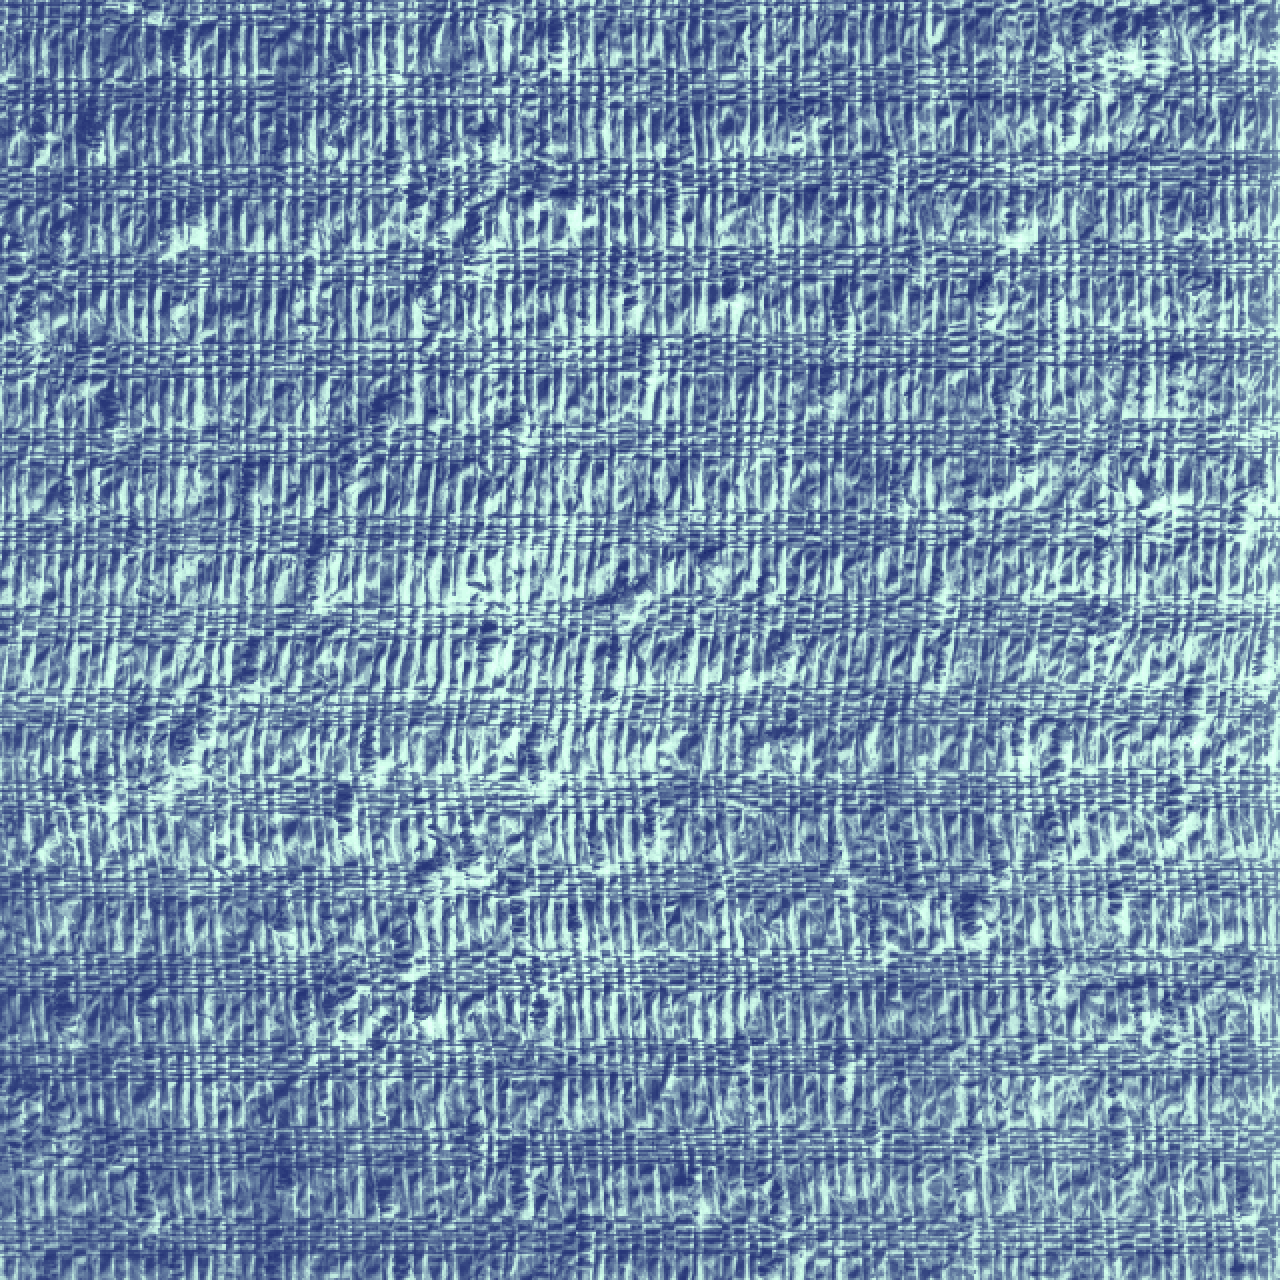

In [4]:
im=skio.imread('banque_images/D80_COLORED.tif')
im = np.atleast_3d(im)
viewimage(im)

In [5]:
def oracle(im,k):
    M,N,C = im.shape
    m = np.mean(im,axis=(0,1))
    tu = (im-m)/np.sqrt(M*N)
    tu_padded = np.zeros((k*M,k*N,C), dtype='float')
    tu_padded[:M,:N,:] = np.copy(tu)

    im_estimation = np.zeros_like(tu_padded, dtype='float')
    W = np.random.normal(0, 1, (tu_padded.shape[:2])).astype(np.float32)

    for c in range(C):
        im_estimation[:, :, c] = m[c] + np.real(ifft2(fft2(np.squeeze(tu_padded[:,:,c]))*fft2(W)))
    
    return im_estimation

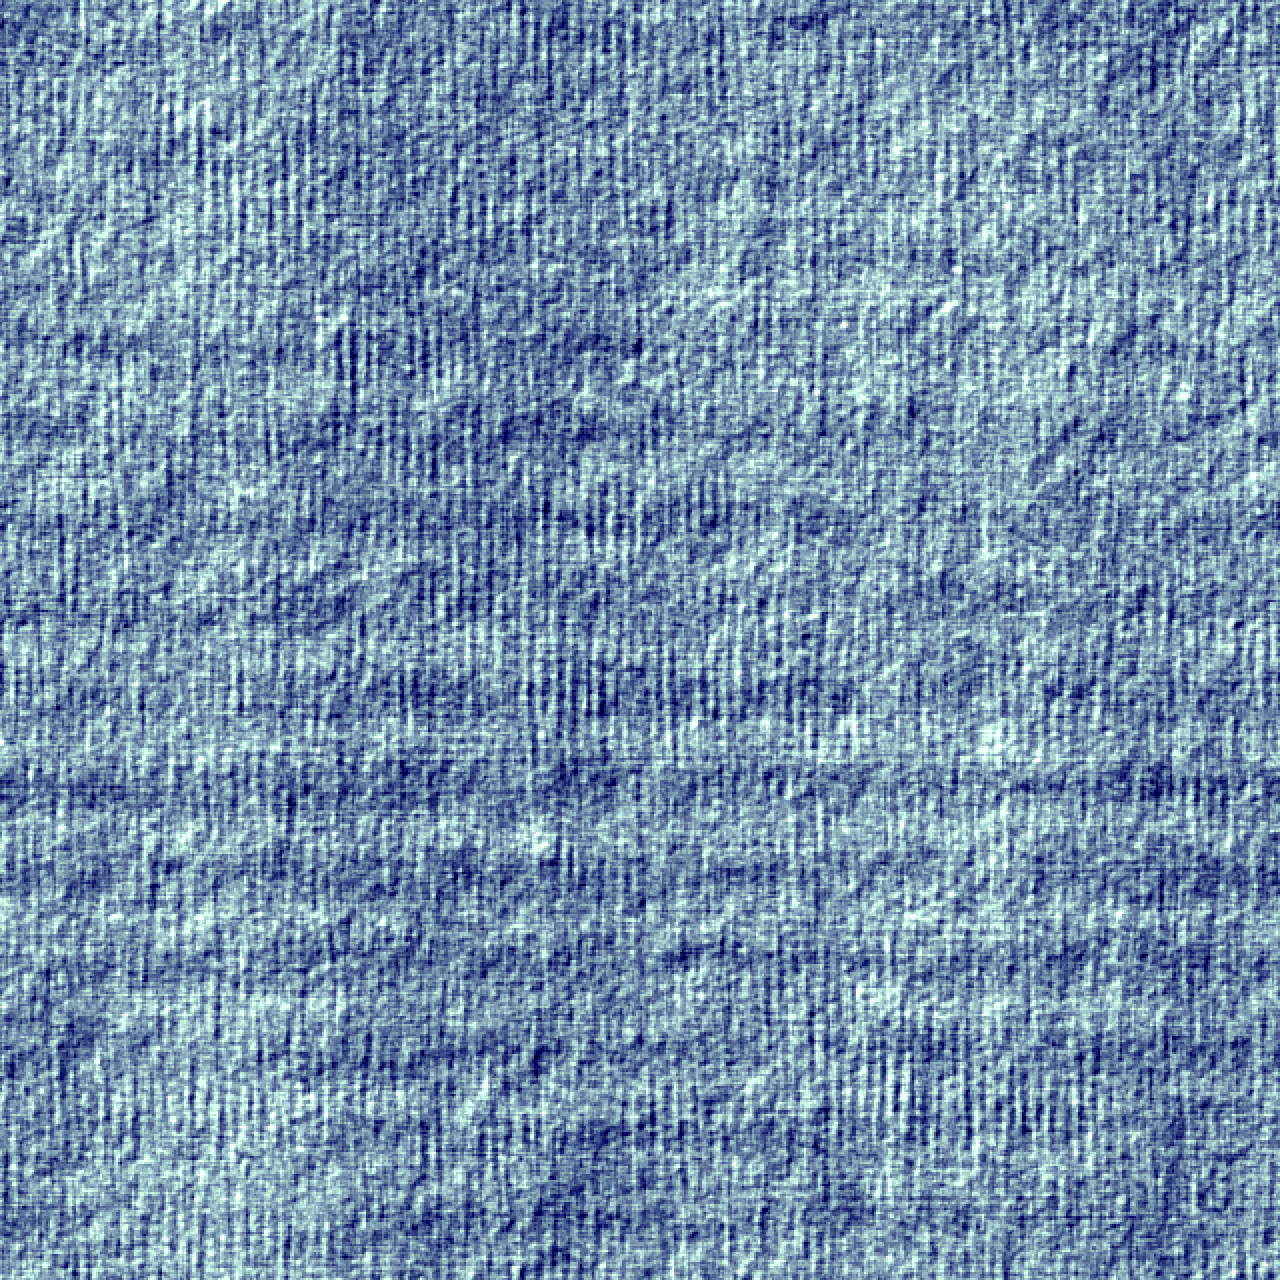

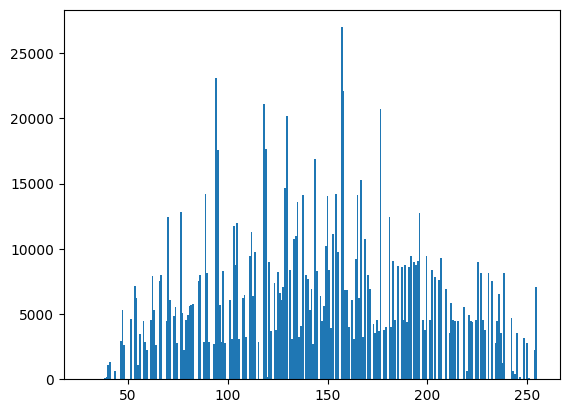

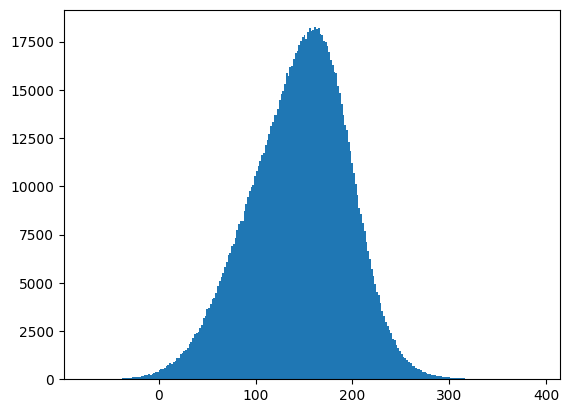

[116.74507568 144.89430664 172.84656738]
[116.74507568 144.89430664 172.84656738]


In [37]:
im_estimation = oracle(im,1)
viewimage(im_estimation)
plt.hist(im.reshape((-1,)),bins=255)
plt.show()
plt.hist(im_estimation.reshape((-1,)),bins=255)
plt.show()
print(np.mean(im, axis=(0, 1)))
print(np.mean(im_estimation, axis=(0, 1)))

In [6]:
def square_mask(M,N,t):
    masked_im = np.ones((M,N))
    masked_im[M//2-t//2:M//2+t//2,N//2-t//2:N//2+t//2] = 0
    return np.atleast_3d(masked_im).astype(np.uint8)

def inverse_mask(mask):
    return (mask + 1) % 2


def get_cst_ker(l):
    return np.ones((l,l))/l**2

def filtre_lineaire(im,mask):
    """ renvoie la convolution de l'image avec le mask. Le calcul se fait en 
utilisant la transformee de Fourier et est donc circulaire.  Fonctionne seulement pour 
les images en niveau de gris.
"""
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out


def border_mask(mask,l):
    bord = filtre_lineaire(np.squeeze(inverse_mask(mask)),get_cst_ker(l))*np.squeeze(mask)
    bord[bord>0.001] = 1
    bord[bord<=0.001] = 0
    return np.atleast_3d(bord).astype(np.uint8)

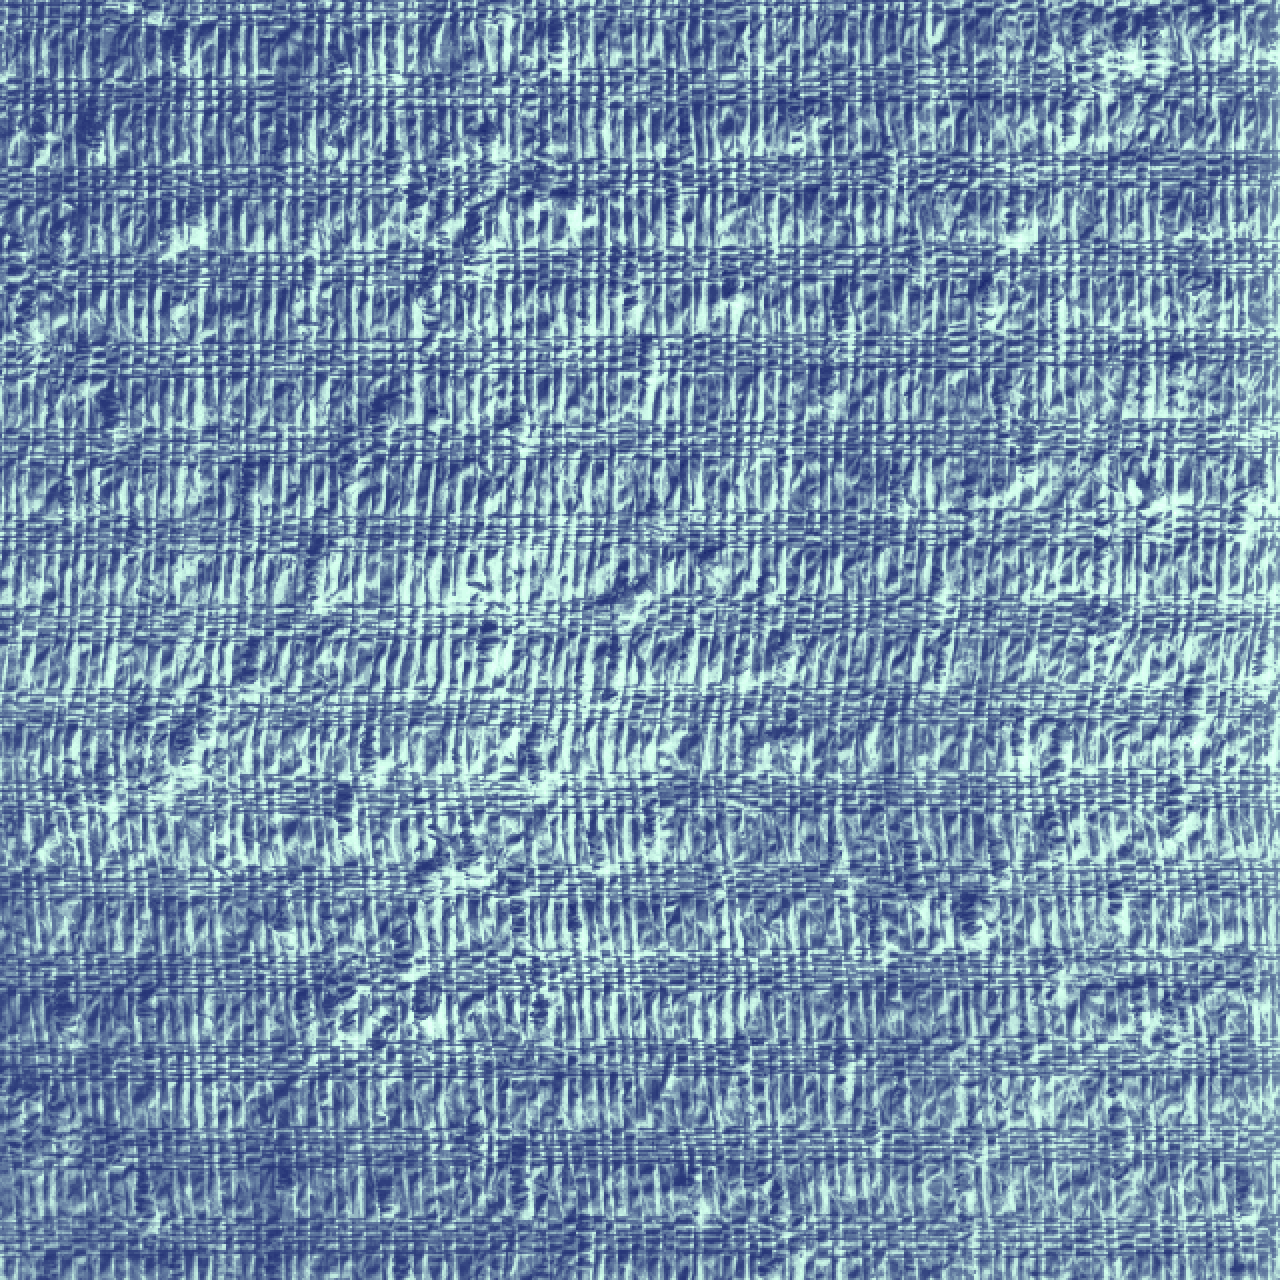

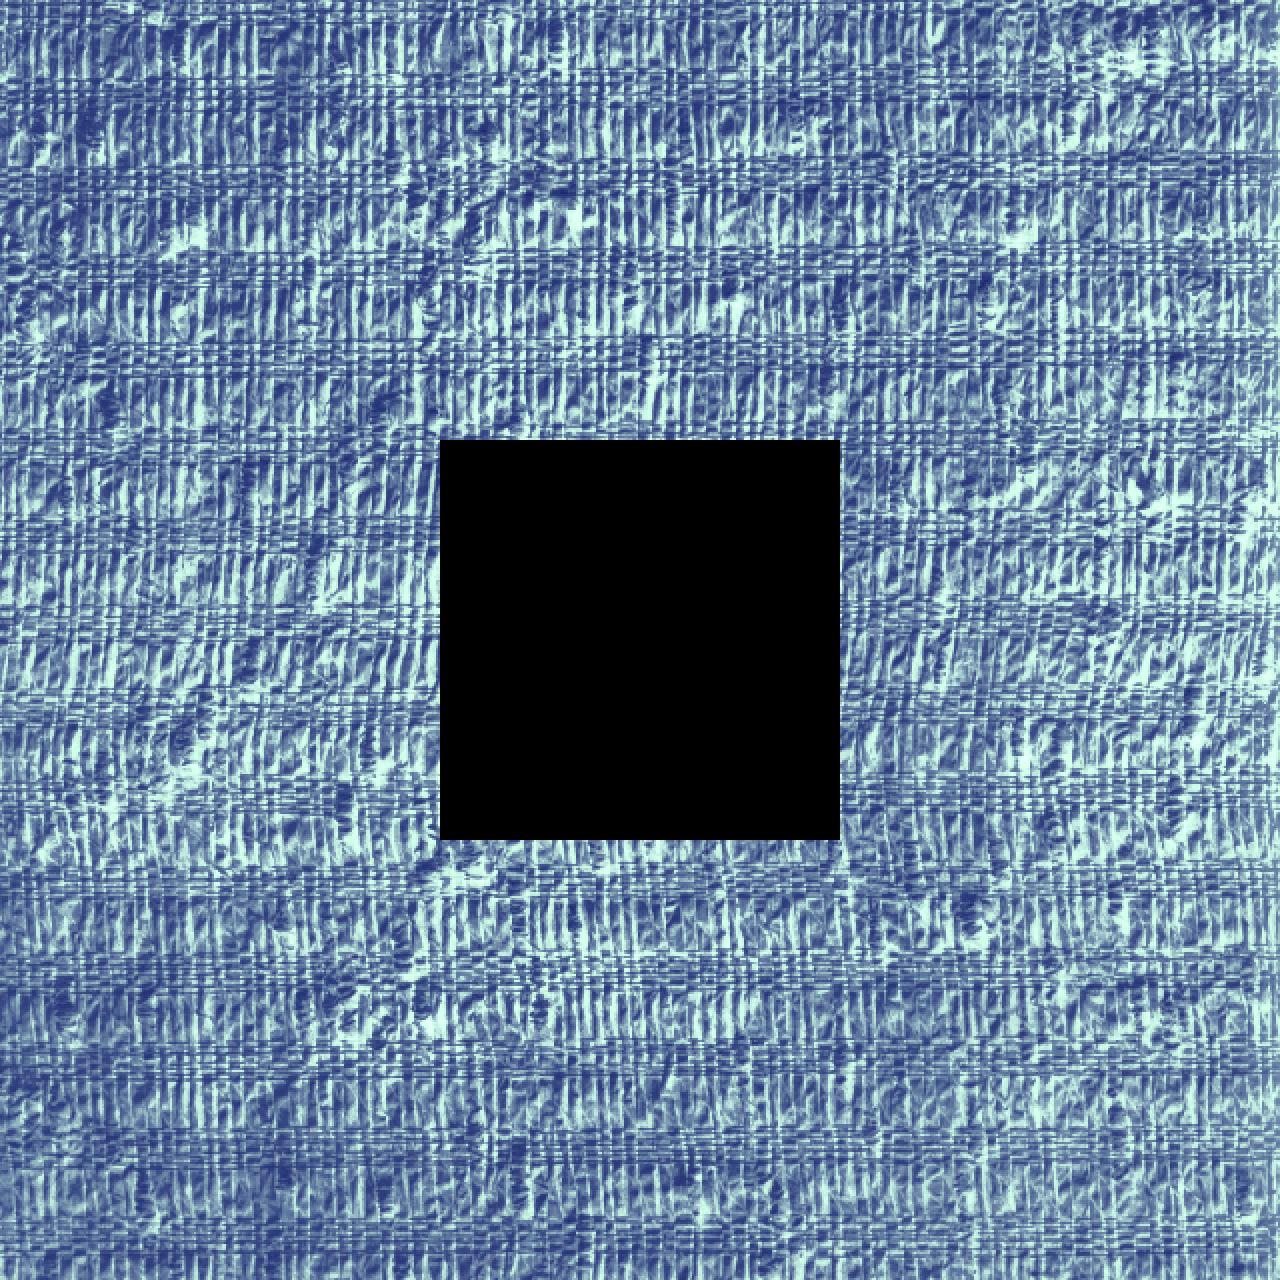

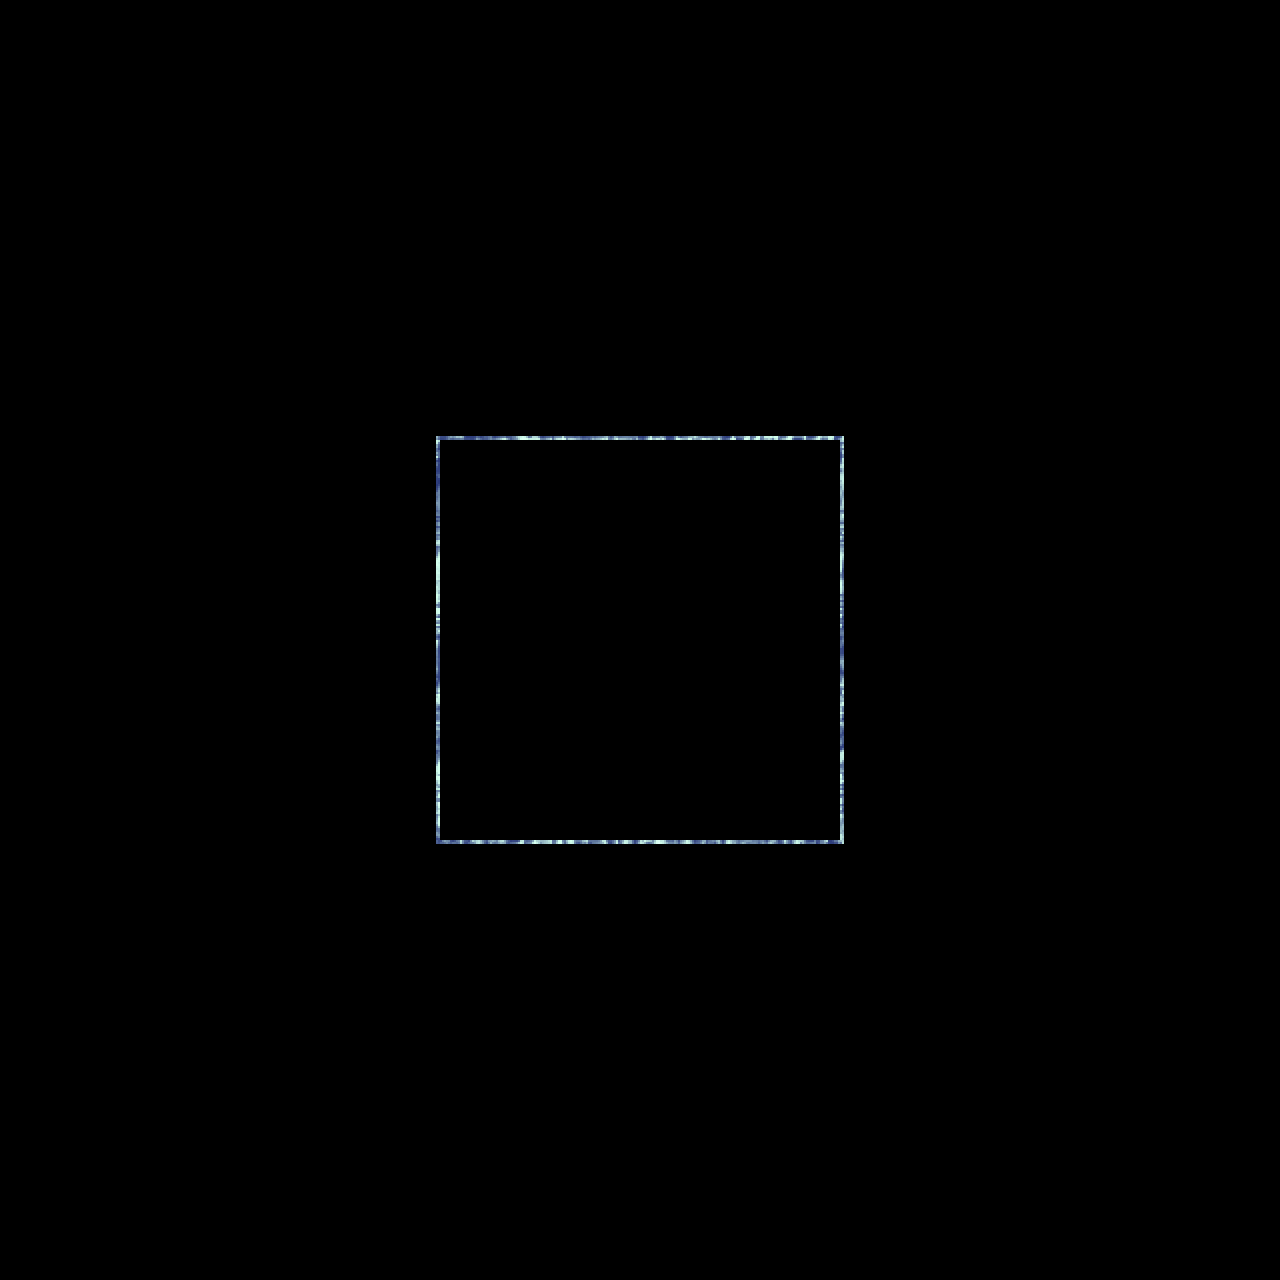

Nombre pixels bordure : 1616


In [44]:
viewimage(im)
mask = square_mask(im.shape[0],im.shape[1],200)
viewimage(im*mask)
border = border_mask(mask,5)
viewimage(im*border)
print(f'Nombre pixels bordure : {np.count_nonzero(border)}') #pb quand on fait im*border plus de pixels

In [7]:
def compute_autocovariance(tv):
    """
    Calcule la covariance croisée normalisée pour une texture tv.
    
    Parameters:
    - tv: Tensor de taille (M, N, C).
    
    Returns:
    - cv: Covariance croisée symétrique (M, N, C, C).
    """
    M, N, C = tv.shape
    cv = np.zeros((M, N, C, C), dtype='float')
    fft_tv = fft2(tv, axes=(0, 1))
    
    for i in range(C):
        for j in range(i, C):  # Calcul uniquement pour la partie triangulaire supérieure
            cv_temp = np.real(ifft2(fft_tv[:, :, i] * np.conj(fft_tv[:, :, j])))
            cv[:, :, i, j] = cv_temp  # Remplir la partie triangulaire supérieure
            cv[:, :, j, i] = cv_temp  # Symétriser
    return cv

def adsn(im,k,mask):

    M,N,C = im.shape
    card_w = np.count_nonzero(mask)
    m = np.sum(im, axis=(0, 1))/card_w
    tv = (im-m)*mask/np.sqrt(card_w)

    cv = compute_autocovariance(tv)

    tv_padded = np.zeros((k*M,k*N,C), dtype='float')
    tv_padded[:M,:N,:] = np.copy(tv)

    im_estimation = np.zeros_like(tv_padded, dtype='float')
    W = np.random.normal(0, 1, (tv_padded.shape[:2])).astype(np.float32)

    for c in range(C):
        im_estimation[:, :, c] = np.real(ifft2(fft2(np.squeeze(tv_padded[:,:,c]))*fft2(W)))
    
    return im_estimation,cv

In [8]:
def visualisation_cv_intercanal(cv,a,b):
    plt.imshow(cv[:,:,a,b], cmap="viridis")
    plt.colorbar()
    plt.title(f'Autocovariance (cv) intercanaux :{a,b}')
    plt.show()
    return

def verify_symmetry(gamma):
    size = gamma.shape[0]
    for i in range(size):
        for j in range(size):
            if not np.allclose(gamma[i, j], gamma[j, i], atol=1e-10):
                print(f"Asymétrie détectée entre les blocs ({i}, {j}) et ({j}, {i})")
                return False
        return True
    
    
def verify_positive_definite(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    print(np.min(eigenvalues))
    return np.all(eigenvalues > 0)


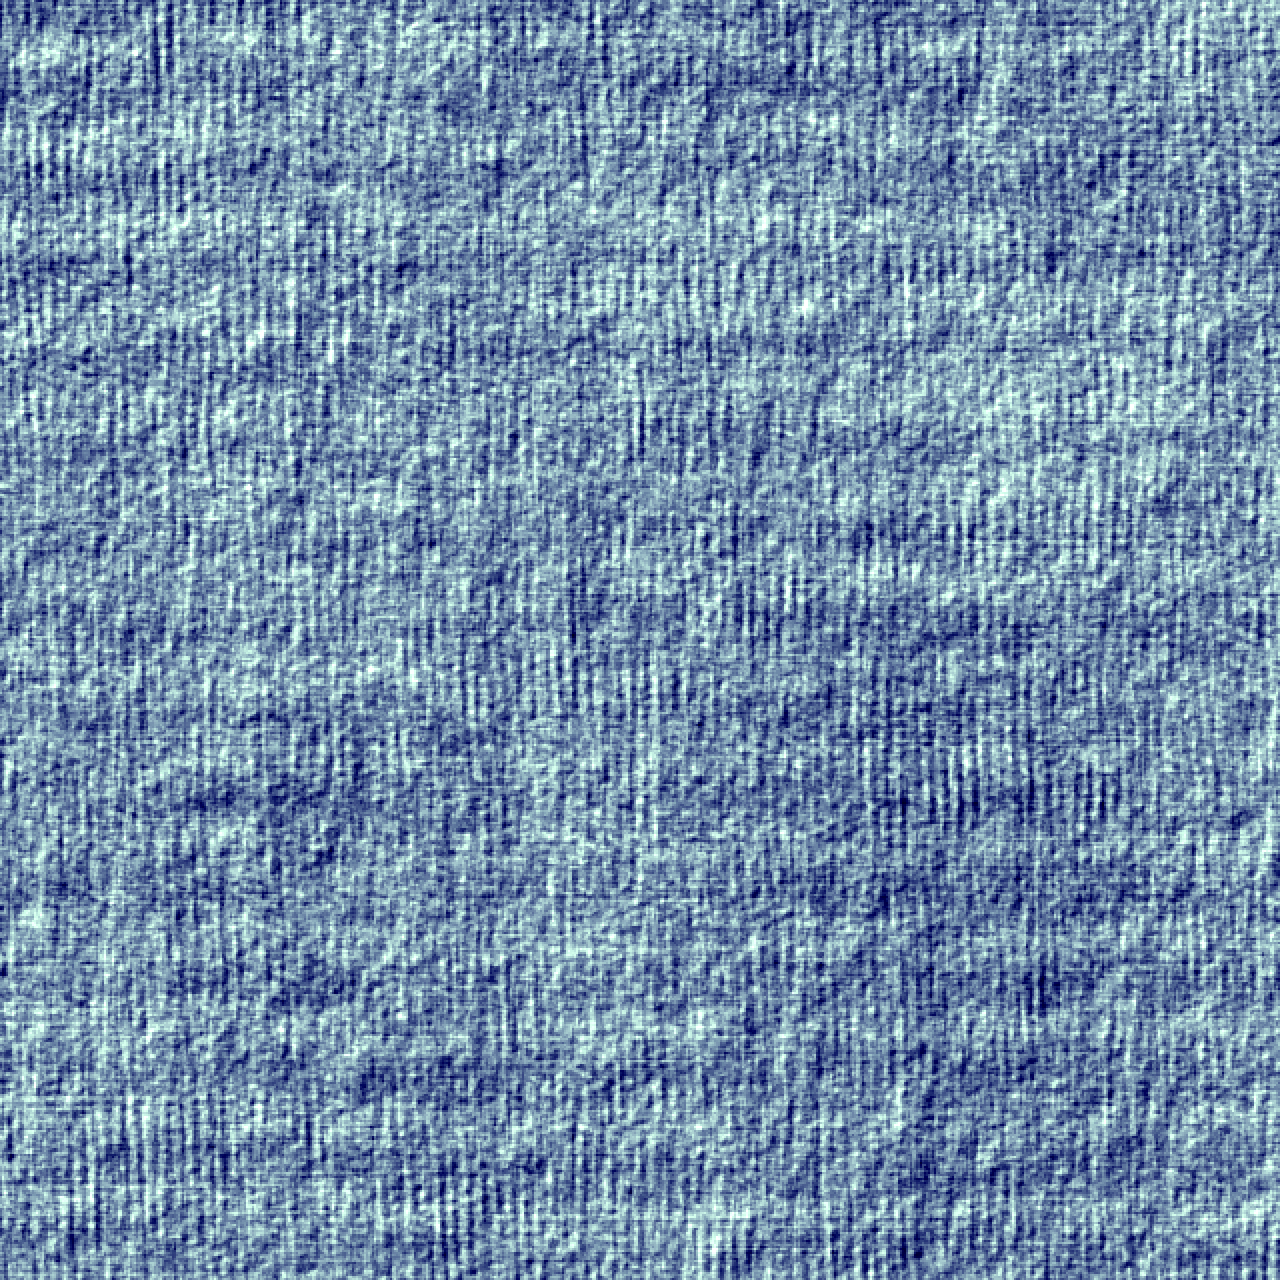

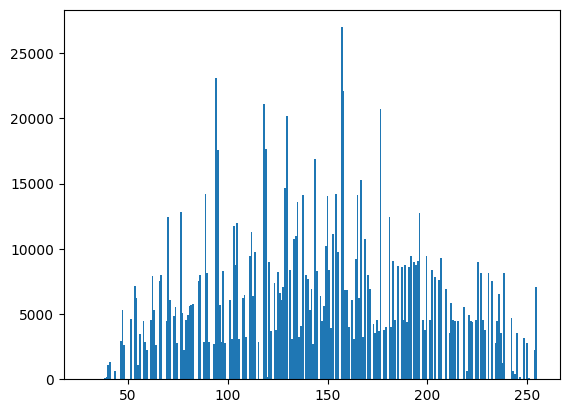

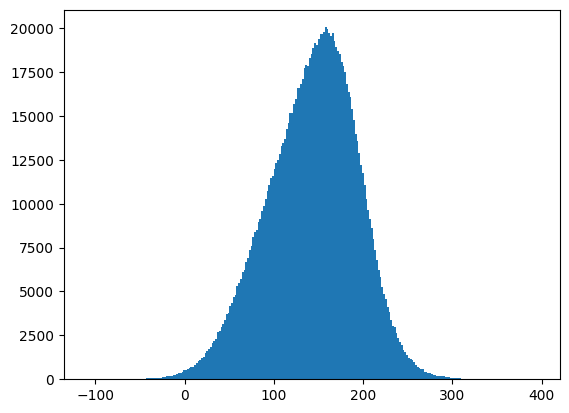

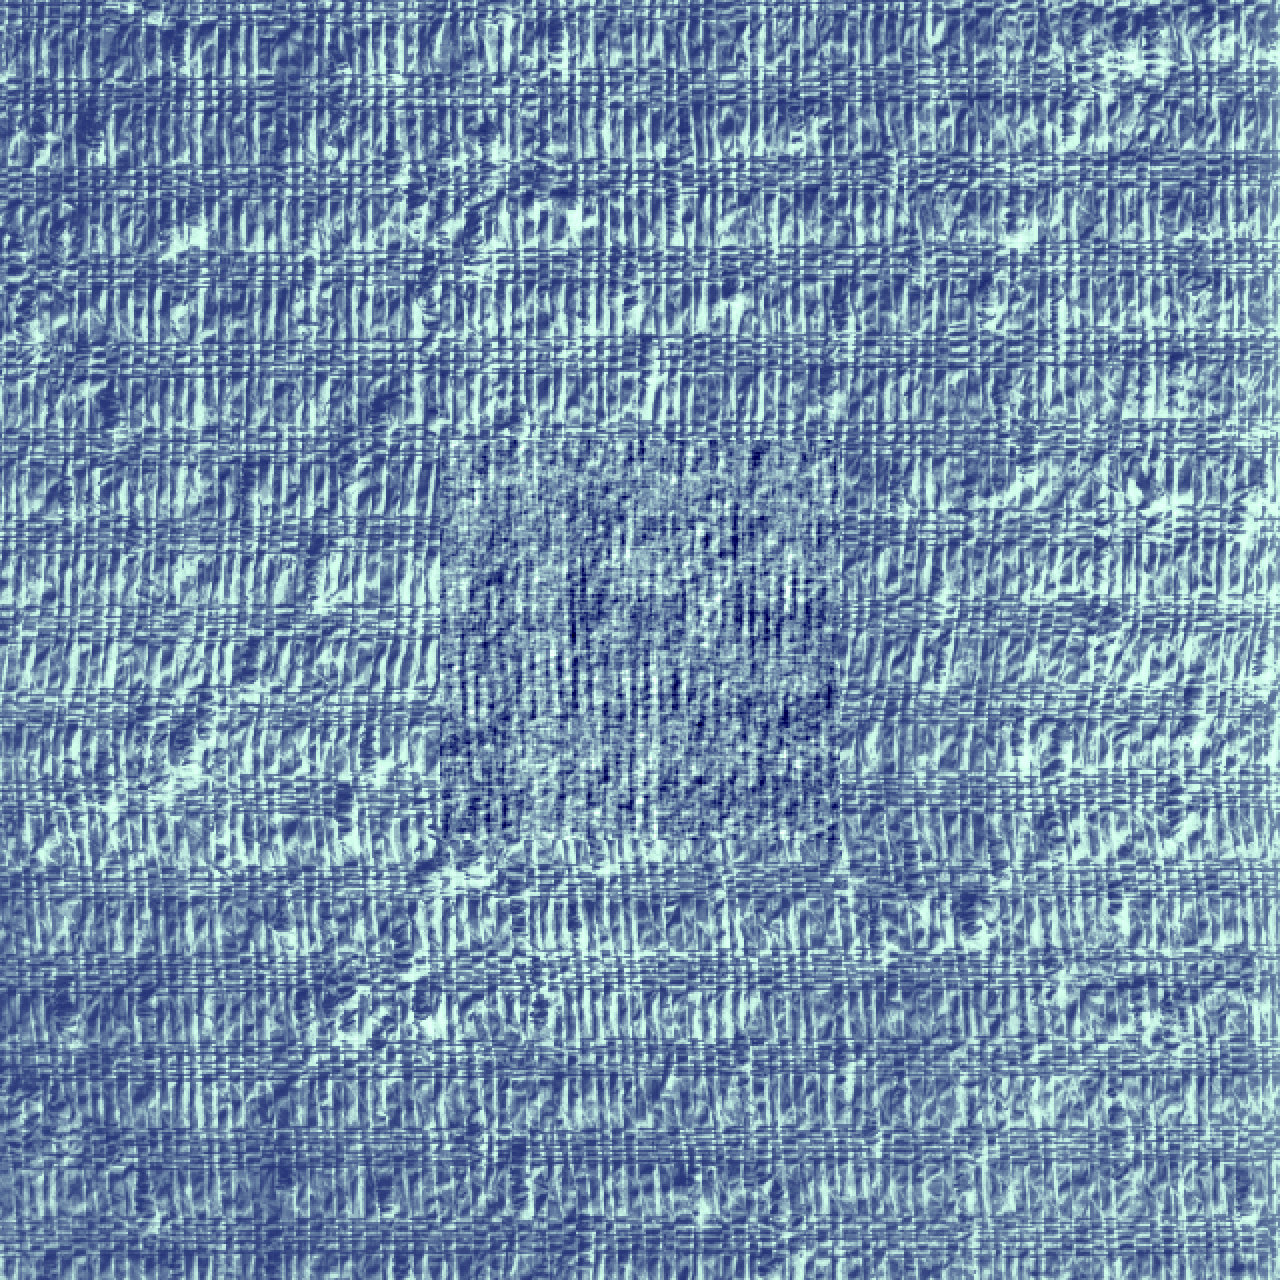

In [50]:
mask = square_mask(im.shape[0],im.shape[1],200)
im_masked = im*mask
im_estimation, cv = adsn(im_masked,2,mask)
im_estimation = np.sum(im_masked, axis=(0, 1))/np.count_nonzero(mask) + im_estimation[:im.shape[0],:im.shape[1],:]
viewimage(im_estimation)
plt.hist(im.reshape((-1,)),bins=255)
plt.show()
plt.hist(im_estimation.reshape((-1,)),bins=255)
plt.show()
viewimage(im_masked + im_estimation*inverse_mask(mask))

In [9]:
def linearize_image_on_C(image, border):
    M, N, C = image.shape

    indices = np.indices((M, N)).reshape(2, -1).T
    
    border_flat = border.reshape(-1)
    
    im_flat = image.reshape(-1, C)
    

    one_indices = np.where(border_flat == 1)[0]
    
    im_reordered = im_flat[one_indices]
    indices_reordered = indices[one_indices]
    
    return im_reordered, indices_reordered


def build_covariance_matrix_on_C(cv,order_C):
    _, _, *C = cv.shape
    size = order_C.shape[0]
    
    gamma = np.zeros((size, size, *C))
    for m in range(size):
        for n in range(size):
            gamma[m,n] = cv[order_C[m][0]-order_C[n][0],order_C[m][1]-order_C[n][1]]
    return gamma

In [10]:
def padding_C_to_omega(psi_C,order_C,shape):
    psi_padded = np.zeros(shape)
    for value, (i, j) in zip(psi_C, order_C):
        psi_padded[i, j] = value
    return psi_padded

def convolve_fft(a,b):
    return np.real(ifft2(fft2(a, axes=(0, 1))*fft2(b, axes=(0, 1)), axes=(0, 1)))

def convolve_cv(a, cv):
    result = np.zeros_like(a, dtype='float')
    C = a.shape[2]
    for i in range(C):  # Canal de sortie
        for j in range(C):  # Canal d'entrée
            # Convolution du canal j vers le canal i
            result[..., i] += convolve_fft(a[..., j],cv[..., j, i])

    return result

'''def convolve_cv(a, cv):
    """
    Convolue une image multicanal (a) avec une matrice de covariance 4D (cv).
    """
    M, N, C = a.shape
    # Étendre les canaux dans une matrice (C * M, C * N)
    extended = np.zeros((C * M, C * N))

    for i in range(C):
        extended[i*M:(i+1)*M, i*N:(i+1)*N] = a[:, :, i]
    
    # Transformer la covariance pour correspondre au format étendu
    cv_matrix = cv.transpose(0, 2, 1, 3).reshape(C * M, C * N)

    # Convolution étendue
    result_extended = convolve_fft(extended, cv_matrix)

    # Transformer le résultat étendu (C * M, C * N) en une image 3D (M, N, C)
    result = np.zeros((M, N, C))
    for i in range(C):
        result[:, :, i] = result_extended[i*M:(i+1)*M, i*N:(i+1)*N]
    
    return result
'''

def solve_system_multi_channel(gamma_C_C, vector_C):
    p, _, d, _ = gamma_C_C.shape  # Taille : (p, p, d, d)
        
    # Aplatir gamma_C_C en une matrice 2D de taille (p*d, p*d)
    gamma_C_C_flat = gamma_C_C.transpose(0, 2, 1, 3).reshape(p * d, p * d)
    print(verify_symmetry(gamma_C_C_flat))
    print(verify_positive_definite(gamma_C_C_flat))
        
    # Aplatir vector_C en un vecteur 1D de taille (p*d)
    vector_C_flat = vector_C.reshape(p * d)
        
    # Résolution du système linéaire
    psi_flat = np.linalg.solve(gamma_C_C_flat, vector_C_flat)
        
    # Reformer psi en taille (p, d)
    psi = psi_flat.reshape(p, d)
    return psi


In [11]:
def conditional_adsn(im,k,mask,border):
    F,cv = adsn(im,k,mask)
    F = F[:im.shape[0],:im.shape[1],:]
    card_w = np.count_nonzero(mask)
    print('F :')
    
    m = np.sum(im, axis=(0, 1))/card_w
    viewimage(m+F)
    for i in range(cv.shape[0]):
        for j in range(cv.shape[1]):
            if not verify_symmetry(cv[i,j]):
                print('PROBLEME')

    print('ADSN :')
    viewimage(m+F)

    im_centree_C, order_C = linearize_image_on_C(im-m,border)
    F_C,_ = linearize_image_on_C(F,border)

    #cv = compute_autocovariance(im - m)

    gamma_C_C = build_covariance_matrix_on_C(cv,order_C)


    psi_im_C = solve_system_multi_channel(gamma_C_C,im_centree_C)
    psi_F_C = solve_system_multi_channel(gamma_C_C,F_C)

    psi_im = padding_C_to_omega(psi_im_C,order_C,im.shape)
    psi_F = padding_C_to_omega(psi_F_C,order_C,im.shape)

    kriging_component = convolve_cv(psi_im, cv)
    innovation_component = convolve_cv(psi_F, cv)

    print('kringing component :')
    viewimage(kriging_component)
    print('innovation component :')
    viewimage(innovation_component)

    conditionnal_synthesis = m + F + kriging_component - innovation_component
    viewimage(conditionnal_synthesis)
    return np.squeeze(im) + np.squeeze(conditionnal_synthesis*inverse_mask(mask)),conditionnal_synthesis

Appuyez sur 'Entrée' lorsque vous avez terminé le masque
masked image :


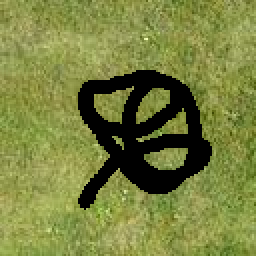

F :


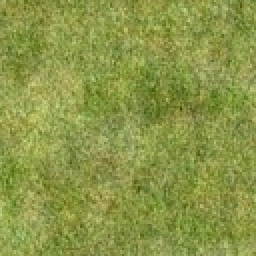

ADSN :


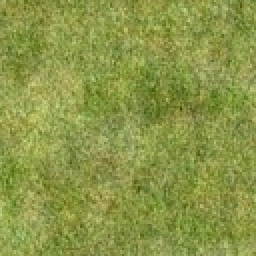

Asymétrie détectée entre les blocs (0, 4) et (4, 0)
False
(0.23879677462640894+0j)
True
Asymétrie détectée entre les blocs (0, 4) et (4, 0)
False
(0.23879677462640894+0j)
True
kringing component :


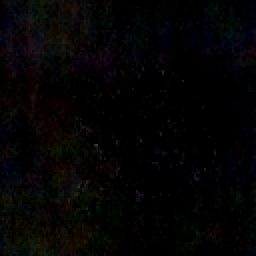

innovation component :


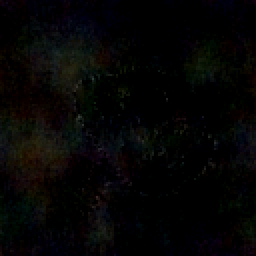

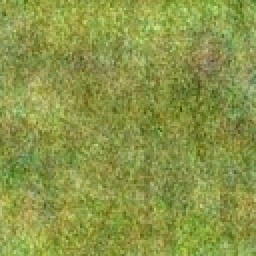

inpainted image :


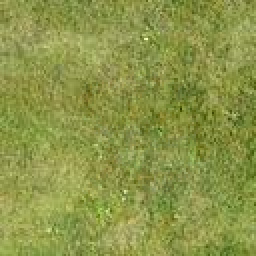

9.203521301918576e-26


In [52]:
image_path = 'images/herbe.jpg'
im=skio.imread(image_path)
im = np.atleast_3d(im)
#mask = square_mask(im.shape[0],im.shape[1],50)
mask = create_mask(image_path,im.shape[2])
border = border_mask(mask,5)
print('masked image :')
viewimage(im*mask)
inpainted, conditionnal_synthesis = conditional_adsn(im*mask,2,mask,border)
print('inpainted image :')
viewimage(np.atleast_3d(inpainted))
im_C, _ = linearize_image_on_C(im,border)
cond_C, _ = linearize_image_on_C(conditionnal_synthesis,border)
print(np.mean((im_C-cond_C)**2))